In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [2]:

def fsin(f):
    rand = np.random.random(size=5)
    x = np.linspace(-1, 1, 32*4)
    y = np.sin((x+rand[0]) * f) * rand[1] + rand[2]
    return y
    

In [3]:
class sorq(Dataset):
    def __init__(
            self,
            length=1000,
            device="cuda:0"
    ):
        self.length = length
        self.device = device

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        rands = np.random.rand(2)
        output = fsin((index%19)*2) * rands[0] + rands[1]*3
        return (torch.tensor(output).view(-1,1).to(self.device).to(torch.float),
                torch.tensor([index%19]).to(self.device).to(torch.float))

    def __str__(self) -> str:
        return f"{self.length}"

dataset = sorq(length=1_0_000)

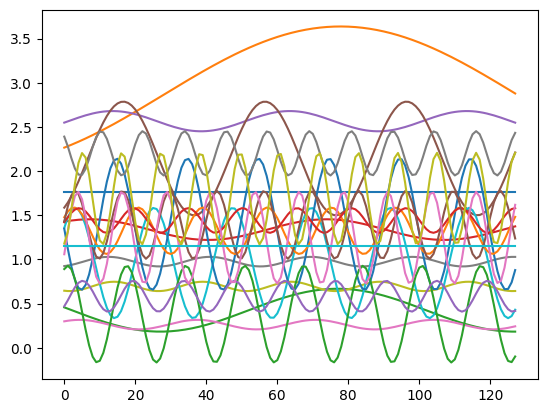

In [4]:
for i in range(0,20):
    # print(dataset[i][1][0].item())
    plt.plot(dataset[i][0].detach().cpu())
plt.show()

In [5]:
class LSTMDiscriminatorRF(nn.Module):
    """An LSTM based discriminator. It expects a sequence as input and outputs a probability for each element. 
    Args:
        in_dim: Input noise dimensionality
        n_layers: number of lstm layers
        hidden_dim: dimensionality of the hidden layer of lstms
    Inputs: sequence of shape (batch_size, seq_len, in_dim)
    Output: sequence of shape (batch_size, seq_len, 1)
    """

    def __init__(self, in_dim,out_dim = 19, n_layers=1, hidden_dim=256):
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
        self.linear_recurrent = nn.Sequential(nn.Linear(hidden_dim, out_dim), nn.Sigmoid())

    def forward(self, input):
        batch_size, seq_len = input.size(0), input.size(1)
        h_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to("cuda:0")
        c_0 = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to("cuda:0")

        recurrent_features, (h_out,c_out) = self.lstm(input, (h_0, c_0))
        outputs = self.linear_recurrent(recurrent_features.contiguous().view(batch_size*seq_len, self.hidden_dim))
        outputs = outputs.view(batch_size, seq_len, self.out_dim)
        return outputs

In [10]:
def spread(label):
    a = torch.zeros(16,19)
    for i,v in enumerate(label):
        a[i][int(v.item())] = 1
    return a.view(16,1,-1).repeat(1,128,1)

In [11]:
# a = spread(label=label)
# a.repeat(1,128,1).shape

In [46]:
batch_size = 16
input_dimenstions = 1
layers = 4
hidden_size = 1024
dataloader = DataLoader(dataset,batch_size=16,shuffle = True)

disc1 = LSTMDiscriminatorRF(input_dimenstions,n_layers=layers,hidden_dim=hidden_size).to("cuda:0")
optimizer1 = optim.Adam(disc1.parameters(), lr=1e-4)
criterion = nn.BCELoss().to(dataset.device)
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[1,5], gamma=0.01)

In [48]:
print("epoch |  bnum  | errD1  | errD2  | errD3  | errD4")
for epoch in range(100):
    for i, (data,label) in enumerate(dataloader, 0):
        # print(data.device,label.device)
        disc1.zero_grad()
        output = disc1(data)
        # print(output.shape,spread(label).shape)
        errD1 = criterion(output,spread(label).to("cuda:0"))
        errD1.backward()
        optimizer1.step()
        print(f"{epoch:5} | {i:6} | {errD1.item():6.3} | {scheduler1.get_lr()}",end = "\r",flush=True)
        if i%100 == 0:
            print()
    scheduler1.step()
    print("\nepoch finished: ",epoch)

epoch |  bnum  | errD1  | errD2  | errD3  | errD4
    0 |      0 |   0.69 | [1.0000000000000002e-08]


C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\optim\lr_scheduler.py:436: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


KeyboardInterrupt: 

In [ ]:
c,label = next(iter(DataLoader(dataset=dataset,batch_size=100,shuffle=True)))
output = disc1(c)

In [ ]:
sfmx = nn.Softmax()

In [ ]:
label.shape

torch.Size([100, 1])

In [ ]:
torch.argmax(sfmx(output[:,-1,:]),dim = 1),label.view(-1)


C:\Users\aashr\AppData\Local\Temp\ipykernel_31936\4077297651.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch.argmax(sfmx(output[:,-1,:]),dim = 1),label.view(-1)


(tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0], device='cuda:0'),
 tensor([11.,  7.,  8., 14.,  2.,  6., 17.,  7.,  3.,  0., 10., 11.,  5., 13.,
          9.,  9.,  9.,  7.,  3., 15., 17., 11.,  1., 17.,  4.,  8.,  2., 13.,
          3.,  7., 10.,  5., 10.,  4., 11., 11.,  0., 11., 17.,  1.,  6.,  4.,
         14., 10., 18., 12.,  2., 17., 14., 17., 13.,  2., 15.,  6., 17., 13.,
         16., 17.,  4.,  8.,  2.,  1.,  1., 11.,  4., 15., 16., 14., 17.,  6.,
         12.,  0.,  1.,  2.,  6., 16., 17., 15.,  0.,  3.,  3.,  1.,  7.,  4.,
          5.,  4.,  4., 12.,  8.,  5., 15.,  5.,  7., 10., 12.,  2., 12.,  0.,
          9.,  9.], device='cuda:0'))

In [ ]:
for i in output[:,-1,:]:
    print(torch.argmax(i))

tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
tensor(0, device='cuda:0')
t